# Test for Stage Machine Learning at La Javaness
# Joseph EL KETTANEH

# Tennis match prediction
## This Project helps to predict the winner of a tennis match 

### This notebook contains the answer to this problem and consists of 4 steps:
- Answering the 4 requested questions:
    - Who are the three ATP players with the most wins?
    - How many sets did the player “Federer R.” win in total?
    - How many sets did the player “Federer R.” win during the years 2016 and 2017?
    - For each match, what is the percentage of victories of the winner in the past?
- Data preparation process
    - Choosing which columns to use(I only used game related columns so i removed bets related ones)
    - Checking and replacing the null values
    - Converting the Data to numeric values
- Feature engineering:
    - Creation of 5 New Features to help the prediction model to do better desicions
    - Performing a One hot encoding on the categorial data
- Training and Testing some machine learning Models:
    - Split the data (2017 for test and the rest for Train)
    - Choosing 5 ml algorithms to train:
        - LogisticRegression(LR)
        - KNeighborsClassifier(Knn)
        - DecisionTreeClassifier(CART)
        - RandomForestClassifier
        - MLPClassifier
    - Comapring the trained models using the metrics:
        - Accuracy Score
        - Recall 
        - F1 score
        - Confusion Matrix
        - ROC Curve
    - Results:
        - CART and Random Forest models had the highest metric scores (<b>Accuracy, Precision, Recall, F1</b>) as shown in the below table. So i chose to check their <b>confusion matrix</b> Random forest model had a slight better result since the TP and TN values on the diagonal are greater.
        - To go furthur i computed the (<b>AUC</b>) area under the (<b>ROC</b>) curve(0.67 for randomForest and 0.65 for CART), Hence it my opinion the Random Forest model had the best performance
        - The scores aren't very good and not very reliable since in my opinion to predict a tennis match winner we need more data like level of fatigue, injuries and more statistics so we can make better feature engineering
        - The models took so much time to train(I coudln't go further with tuning > 30 mins) but they need better hyperparameter tuning so we can get higher scores and better accuracy

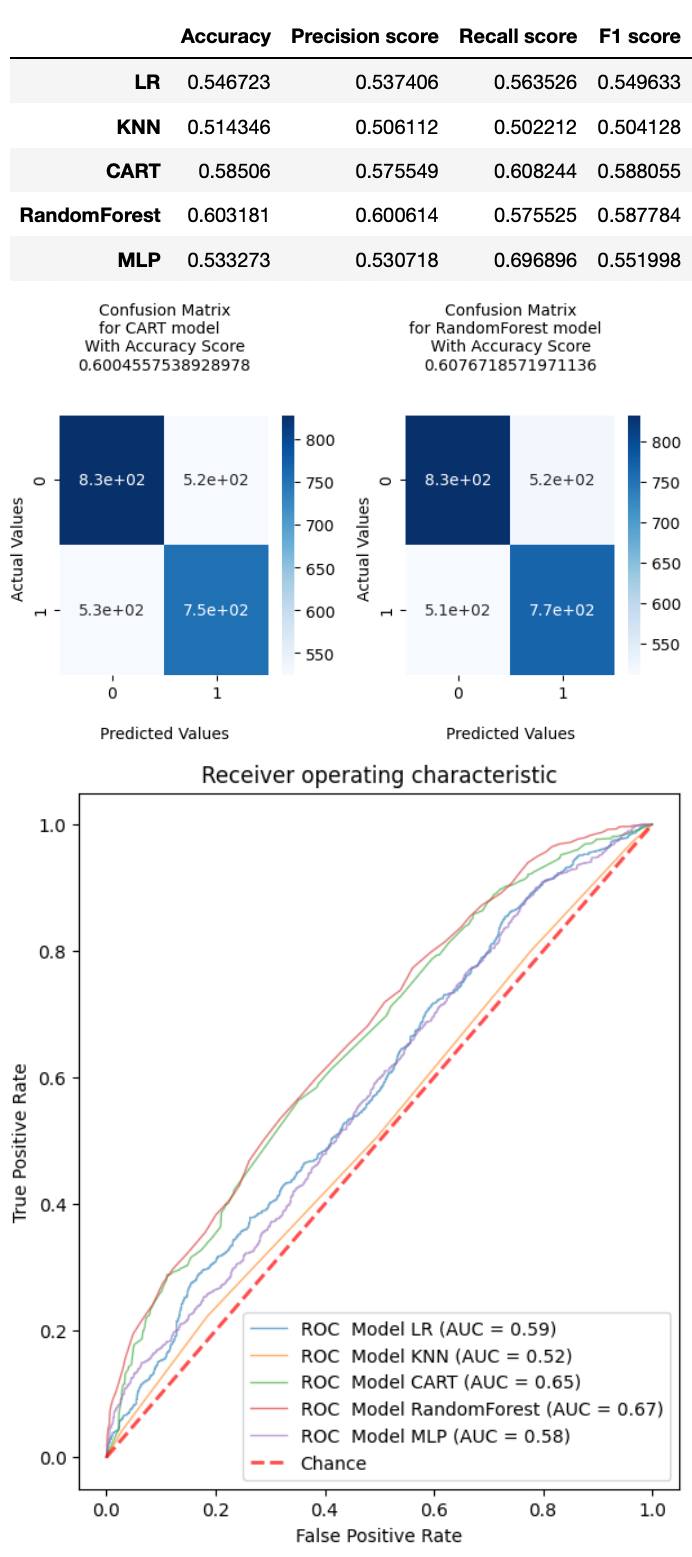

In [69]:
import pandas as pd
import numpy as np
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
logging.getLogger().setLevel('INFO')

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
# We will be using the accuracy, precision,recall and the f1  as scores to asses our model performence
#Importing most important alogorithms 
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn import model_selection #Cross-validation multiple scoring function


import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

## Helpers

In [70]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset

In [ ]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

## Data Discovery and analysis

    Key to results data:

    ATP = Tournament number (men)
    WTA = Tournament number (women)
    Location = Venue of tournament
    Tournament = Name of tounament (including sponsor if relevant)
    Date = Date of match (note: prior to 2003 the date shown for all matches played in a single tournament is the start date)
    Series = Name of ATP tennis series (Grand Slam, Masters, International or International Gold)
    Tier = Tier (tournament ranking) of WTA tennis series.
    Court = Type of court (outdoors or indoors)
    Surface = Type of surface (clay, hard, carpet or grass)
    Round = Round of match
    Best of = Maximum number of sets playable in match
    Winner = Match winner
    Loser = Match loser
    WRank = ATP Entry ranking of the match winner as of the start of the tournament
    LRank = ATP Entry ranking of the match loser as of the start of the tournament
    WPts = ATP Entry points of the match winner as of the start of the tournament
    LPts = ATP Entry points of the match loser as of the start of the tournament
    W1 = Number of games won in 1st set by match winner
    L1 = Number of games won in 1st set by match loser
    W2 = Number of games won in 2nd set by match winner
    L2 = Number of games won in 2nd set by match loser
    W3 = Number of games won in 3rd set by match winner
    L3 = Number of games won in 3rd set by match loser
    W4 = Number of games won in 4th set by match winner
    L4 = Number of games won in 4th set by match loser
    W5 = Number of games won in 5th set by match winner
    L5 = Number of games won in 5th set by match loser
    Wsets = Number of sets won by match winner
    Lsets = Number of sets won by match loser
    Comment = Comment on the match (Completed, won through retirement of loser, or via Walkover)
    
##### source: http://www.tennis-data.co.uk/notes.txt


In [72]:
df_atp.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1. Who are the three ATP players with the most wins?

In [73]:
df_top3_winners = (df_atp['Winner'].value_counts()).head(3)
print("\n\nThe Top 3 players are:")
df_top3_winners



The Top 3 players are:


Federer R.     1121
Nadal R.        891
Djokovic N.     802
Name: Winner, dtype: int64

### 2. How many sets did the player “Federer R.” win in total?
Here we are interested in the columns: 
   - <b>Wsets</b> = Number of sets won by match winner
   - <b>Lsets</b> = Number of sets won by match loser

In [74]:
#Converting Lsets to numeric since it has a string type so we can do the addition 
df_atp['Lsets']= pd.to_numeric(df_atp['Lsets'], errors='coerce')

df_l_f = df_atp.query("Loser=='Federer R.'")['Lsets'].sum()
df_w_f = df_atp.query("Winner=='Federer R.'")['Wsets'].sum()

num_won_sets = df_w_f + df_l_f

print("\n\nFederer R. won ", num_won_sets, " sets in total\n\n")




Federer R. won  2695.0  sets in total




### 3. How many sets did the player “Federer R.” win during the years 2016 and 2017?

Here we should compute the sum between the won sets of Federer R. using <b>Wsets</b> and <b>Lsets</b> only in 2016 and 2017

In [75]:

df_l_f_1617 = df_atp.query("Loser=='Federer R.' and '2016-01-01'<=Date<='2017-12-31'")["Lsets"].sum()
df_w_f_1617 = df_atp.query("Winner=='Federer R.' and '2016-01-01'<=Date<='2017-12-31'")["Wsets"].sum()

num_won_sets_1617 = df_l_f_1617 + df_w_f_1617

print("\n\nDuring the years 2016 and 2017 Federer R. won ", num_won_sets_1617, " sets\n\n")



During the years 2016 and 2017 Federer R. won  182.0  sets




### 4. For each match, what is the percentage of victories of the winner in the past?

For every player we should collect the perevious games where he was a loser or a winner and compute the percentage

In [76]:
def previous_w_percentage(player,date, df_atp):
    minimum_played_games = 2
    df_previous  = df_atp[df_atp["Date"] < date]
    previous_wins = df_previous[df_previous["Winner"] == player].shape[0]
    previous_losses = df_previous[df_previous["Loser"] == player].shape[0]
    
    if  minimum_played_games > (previous_wins + previous_losses):
        return 0
    return previous_wins / (previous_wins + previous_losses)

In [77]:
df_atp["winner_previous_win_percentage"] = df_atp.apply(
    lambda row: previous_w_percentage(
        row["Winner"],
        row["Date"],
        df_atp
    ),
    axis=1
)

In [78]:
#df_atp.to_csv("atp_previous_win_percentage.csv")
df_atp_prev_per = pd.read_csv("atp_previous_win_percentage.csv")
df_atp_prev_per

,Unnamed: 0,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,...,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,winner_previous_win_percentage
0,0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,1,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,2,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,3,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,4,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,52293,67,London,Masters Cup,2018-11-16,Masters Cup,Indoor,Hard,Round Robin,3,...,NaN,NaN,NaN,NaN,NaN,1.44,3.40,1.38,3.14,0.664032
52294,52294,67,London,Masters Cup,2018-11-16,Masters Cup,Indoor,Hard,Round Robin,3,...,NaN,NaN,NaN,NaN,NaN,1.22,6.03,1.17,5.14,0.829876
52295,52295,67,London,Masters Cup,2018-11-17,Masters Cup,Indoor,Hard,Semifinals,3,...,NaN,NaN,NaN,NaN,NaN,3.40,1.45,3.14,1.38,0.665354
52296,52296,67,London,Masters Cup,2018-11-17,Masters Cup,Indoor,Hard,Semifinals,3,...,NaN,NaN,NaN,NaN,NaN,1.15,7.72,1.12,6.52,0.830052


## Data preparation process

We need to keep only the data that's related to the match that will help us to predict the winner, without taking into consideration the betting data

In [79]:
gamesColumns = ['Tournament','Series','Date','Round'
                ,'Court','Surface'
                ,'Lsets','Wsets','LPts','WPts','LRank','WRank'
                ,'Best of'
                ,'Loser','Winner']

df_atp_pre = df_atp[gamesColumns].copy()
df_atp_pre["winner_previous_win_percentage"] = df_atp_prev_per["winner_previous_win_percentage"]
df_atp_pre

,Tournament,Series,Date,Round,Court,Surface,Lsets,Wsets,LPts,WPts,LRank,WRank,Best of,Loser,Winner,winner_previous_win_percentage
0,Australian Hardcourt Championships,International,2000-01-03,1st Round,Outdoor,Hard,0.0,2.0,NaN,NaN,77,63,3,Ljubicic I.,Dosedel S.,0.000000
1,Australian Hardcourt Championships,International,2000-01-03,1st Round,Outdoor,Hard,0.0,2.0,NaN,NaN,56,5,3,Clement A.,Enqvist T.,0.000000
2,Australian Hardcourt Championships,International,2000-01-03,1st Round,Outdoor,Hard,1.0,2.0,NaN,NaN,655,40,3,Baccanello P.,Escude N.,0.000000
3,Australian Hardcourt Championships,International,2000-01-03,1st Round,Outdoor,Hard,0.0,2.0,NaN,NaN,87,65,3,Knippschild J.,Federer R.,0.000000
4,Australian Hardcourt Championships,International,2000-01-03,1st Round,Outdoor,Hard,1.0,2.0,NaN,NaN,198,81,3,Woodbridge T.,Fromberg R.,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,Masters Cup,Masters Cup,2018-11-16,Round Robin,Indoor,Hard,0.0,2.0,3155.0,5085.0,10.0,5,3,Isner J.,Zverev A.,0.664032
52294,Masters Cup,Masters Cup,2018-11-16,Round Robin,Indoor,Hard,0.0,2.0,4050.0,8045.0,7.0,1,3,Cilic M.,Djokovic N.,0.829876
52295,Masters Cup,Masters Cup,2018-11-17,Semifinals,Indoor,Hard,0.0,2.0,6020.0,5085.0,3.0,5,3,Federer R.,Zverev A.,0.665354
52296,Masters Cup,Masters Cup,2018-11-17,Semifinals,Indoor,Hard,0.0,2.0,4310.0,8045.0,6.0,1,3,Anderson K.,Djokovic N.,0.830052


##### Checking the null values

In [80]:
df_null_values = pd.DataFrame(df_atp_pre.isnull().sum() / len(df_atp_pre) *100, columns=["Percent_of_missing_data"])
df_null_values.sort_values(ascending=False,by="Percent_of_missing_data")

,Percent_of_missing_data
LPts,31.096791
WPts,30.983976
Lsets,0.432139
Wsets,0.428315
LRank,0.149145
WRank,0.028682
Tournament,0.000000
Series,0.000000
Date,0.000000
Round,0.000000


In [81]:
df_atp_pre.describe(include="all", datetime_is_numeric=True)

,Tournament,Series,Date,Round,Court,Surface,Lsets,Wsets,LPts,WPts,LRank,WRank,Best of,Loser,Winner,winner_previous_win_percentage
count,52298,52298,52298,52298,52298,52298,52072.000000,52074.000000,36035.000000,36094.000000,52220.0,52283.0,52298.000000,52298,52298,52298.000000
unique,214,8,NaN,8,2,4,NaN,NaN,NaN,NaN,943.0,604.0,NaN,1483,948,NaN
top,US Open,International,NaN,1st Round,Outdoor,Hard,NaN,NaN,NaN,NaN,46.0,1.0,NaN,Lopez F.,Federer R.,NaN
freq,2413,12204,NaN,24212,42941,27716,NaN,NaN,NaN,NaN,464.0,1172.0,NaN,415,1121,NaN
mean,NaN,NaN,2009-03-08 20:13:59.802669312,NaN,NaN,NaN,0.407801,2.141760,1047.544665,1831.891644,NaN,NaN,3.372366,NaN,NaN,0.520222
min,NaN,NaN,2000-01-03 00:00:00,NaN,NaN,NaN,0.000000,0.000000,1.000000,1.000000,NaN,NaN,3.000000,NaN,NaN,0.000000
25%,NaN,NaN,2004-06-10 00:00:00,NaN,NaN,NaN,0.000000,2.000000,496.000000,640.000000,NaN,NaN,3.000000,NaN,NaN,0.439130
50%,NaN,NaN,2009-02-03 00:00:00,NaN,NaN,NaN,0.000000,2.000000,736.000000,1007.000000,NaN,NaN,3.000000,NaN,NaN,0.525868
75%,NaN,NaN,2014-01-01 00:00:00,NaN,NaN,NaN,1.000000,2.000000,1141.000000,1895.000000,NaN,NaN,3.000000,NaN,NaN,0.611111
max,NaN,NaN,2018-11-18 00:00:00,NaN,NaN,NaN,2.000000,3.000000,16950.000000,16950.000000,NaN,NaN,5.000000,NaN,NaN,1.000000


##### Replacing the 'NR' in WRank and LRank by Nan values so i can be able to replace it easily 

In [82]:
naRankIndW = df_atp_pre.loc[:,'WRank'].apply(lambda x: x=='NR') 
naRankIndL = df_atp_pre.loc[:,'LRank'].apply(lambda x: x=='NR')
df_atp_pre.loc[naRankIndW,'WRank'] = np.NaN
df_atp_pre.loc[naRankIndL,'LRank'] = np.NaN

##### Replacing the null values by their mean value

In [83]:
columns=['WPts','LPts','Lsets','Wsets','LRank','WRank']
#columns=['WPts','LPts']
for column in columns:
    df_atp_pre[column]=df_atp_pre[column].fillna(float(df_atp_pre[column].mean()))

##### Making sure we don't have anymore Null Values

In [84]:
df_null_values = pd.DataFrame(df_atp_pre.isna().sum() / len(df_atp_pre) *100, columns=["Percent_of_missing_data"])
df_null_values.sort_values(ascending=False,by="Percent_of_missing_data")

,Percent_of_missing_data
Tournament,0.0
Series,0.0
Date,0.0
Round,0.0
Court,0.0
Surface,0.0
Lsets,0.0
Wsets,0.0
LPts,0.0
WPts,0.0


##### Converting the Date column to Float values

In [85]:
df_atp_pre["Date"] = df_atp_pre["Date"].apply(lambda x : x.year + (x.month-1)/12 + x.day/365)

In [86]:
df_atp_pre

,Tournament,Series,Date,Round,Court,Surface,Lsets,Wsets,LPts,WPts,LRank,WRank,Best of,Loser,Winner,winner_previous_win_percentage
0,Australian Hardcourt Championships,International,2000.008219,1st Round,Outdoor,Hard,0.0,2.0,1047.544665,1831.891644,77.0,63.0,3,Ljubicic I.,Dosedel S.,0.000000
1,Australian Hardcourt Championships,International,2000.008219,1st Round,Outdoor,Hard,0.0,2.0,1047.544665,1831.891644,56.0,5.0,3,Clement A.,Enqvist T.,0.000000
2,Australian Hardcourt Championships,International,2000.008219,1st Round,Outdoor,Hard,1.0,2.0,1047.544665,1831.891644,655.0,40.0,3,Baccanello P.,Escude N.,0.000000
3,Australian Hardcourt Championships,International,2000.008219,1st Round,Outdoor,Hard,0.0,2.0,1047.544665,1831.891644,87.0,65.0,3,Knippschild J.,Federer R.,0.000000
4,Australian Hardcourt Championships,International,2000.008219,1st Round,Outdoor,Hard,1.0,2.0,1047.544665,1831.891644,198.0,81.0,3,Woodbridge T.,Fromberg R.,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,Masters Cup,Masters Cup,2018.877169,Round Robin,Indoor,Hard,0.0,2.0,3155.000000,5085.000000,10.0,5.0,3,Isner J.,Zverev A.,0.664032
52294,Masters Cup,Masters Cup,2018.877169,Round Robin,Indoor,Hard,0.0,2.0,4050.000000,8045.000000,7.0,1.0,3,Cilic M.,Djokovic N.,0.829876
52295,Masters Cup,Masters Cup,2018.879909,Semifinals,Indoor,Hard,0.0,2.0,6020.000000,5085.000000,3.0,5.0,3,Federer R.,Zverev A.,0.665354
52296,Masters Cup,Masters Cup,2018.879909,Semifinals,Indoor,Hard,0.0,2.0,4310.000000,8045.000000,6.0,1.0,3,Anderson K.,Djokovic N.,0.830052


## Feature engineering

- I created 5 New Features to help the prediction model with doing better desicions:
    - <b>GameWinner</b>: It's the Label of the Dataset(0 if player1 wins and 1 if player2 wins)
    - <b>player1_Vs_player2</b>: The number of times when player1 wins over player2
    - <b>player2_Vs_player1</b>: The number of times when player2 wins over player1
    - <b>points_diff</b>: Players Entry points difference as of the start of the tournament
    - <b>rank_diff</b>: Difference of Entry ranks of the players as of the start of the tournament
    
- I did an <b>One hot encoding</b> on the categorial data ("Series","Court","Surface","Round","Best of","Tournament")

Creating 2 features Player1 and Player2 and i filled them from Winner and Loser columns by alphabetic order so we can have a better distribution of the data. This will help to create a Label column with 2 classes 0 and 1.(To be deleted later)

In [87]:
df_atp_pre["Player1"] = df_atp.apply(lambda row: row["Winner"] if row["Winner"] < row["Loser"] else row["Loser"], axis=1)
df_atp_pre["Player2"] = df_atp.apply(lambda row: row["Winner"] if row["Winner"] > row["Loser"] else row["Loser"], axis=1)

Creating the label Feature GameWinner so if Player1 is the winner we assign a 0 and if player2 is the winner we assign 1

In [88]:
df_atp_pre['GameWinner'] = df_atp_pre.apply(lambda row: 0 if row["Winner"] == row["Player1"] else 1, axis=1)

Making sure the data is well distributed

In [89]:
print("Nb of Individuals in Class 0 :", df_atp_pre[df_atp_pre["GameWinner"] == 0].shape[0])
print("Nb of Individuals in Class 1 :", df_atp_pre[df_atp_pre["GameWinner"] == 1].shape[0])


Nb of Individuals in Class 0 : 26602
Nb of Individuals in Class 1 : 25696


How many times player1 won over player2

I created a new Feature player1_Vs_player2 to compute how many games player1 won over player2

In [90]:
def player1_Vs_player2(player1, player2 ,date, df_atp, mode = 1):
    
    df_previous  = df_atp[df_atp["Date"] < date]
    
    if mode == 1:
        cond = (df_previous["Winner"] == player1) & (df_previous["Loser"] == player2)
    else:
        cond = (df_previous["Winner"] == player2) & (df_previous["Loser"] == player1)
        
    previous_wins = df_previous[cond].shape[0]
    
    return previous_wins

In [91]:
df_atp_pre["player1_Vs_player2"] = df_atp_pre.apply(
    lambda row: player1_Vs_player2(
        row["Player1"],
        row["Player2"],
        row["Date"],
        df_atp_pre,
        1
    ),
    axis=1
)

How many times player2 won over player1

I created a new Feature player2_Vs_player1 to compute how many games player2 won over player1

In [92]:
df_atp_pre["player2_Vs_player1"] = df_atp_pre.apply(
    lambda row: player1_Vs_player2(
        row["Player1"],
        row["Player2"],
        row["Date"],
        df_atp_pre,
        2
    ),
    axis=1
)

In [93]:
df_atp_pre

,Tournament,Series,Date,Round,Court,Surface,Lsets,Wsets,LPts,WPts,...,WRank,Best of,Loser,Winner,winner_previous_win_percentage,Player1,Player2,GameWinner,player1_Vs_player2,player2_Vs_player1
0,Australian Hardcourt Championships,International,2000.008219,1st Round,Outdoor,Hard,0.0,2.0,1047.544665,1831.891644,...,63.0,3,Ljubicic I.,Dosedel S.,0.000000,Dosedel S.,Ljubicic I.,0,0,0
1,Australian Hardcourt Championships,International,2000.008219,1st Round,Outdoor,Hard,0.0,2.0,1047.544665,1831.891644,...,5.0,3,Clement A.,Enqvist T.,0.000000,Clement A.,Enqvist T.,1,0,0
2,Australian Hardcourt Championships,International,2000.008219,1st Round,Outdoor,Hard,1.0,2.0,1047.544665,1831.891644,...,40.0,3,Baccanello P.,Escude N.,0.000000,Baccanello P.,Escude N.,1,0,0
3,Australian Hardcourt Championships,International,2000.008219,1st Round,Outdoor,Hard,0.0,2.0,1047.544665,1831.891644,...,65.0,3,Knippschild J.,Federer R.,0.000000,Federer R.,Knippschild J.,0,0,0
4,Australian Hardcourt Championships,International,2000.008219,1st Round,Outdoor,Hard,1.0,2.0,1047.544665,1831.891644,...,81.0,3,Woodbridge T.,Fromberg R.,0.000000,Fromberg R.,Woodbridge T.,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,Masters Cup,Masters Cup,2018.877169,Round Robin,Indoor,Hard,0.0,2.0,3155.000000,5085.000000,...,5.0,3,Isner J.,Zverev A.,0.664032,Isner J.,Zverev A.,1,1,4
52294,Masters Cup,Masters Cup,2018.877169,Round Robin,Indoor,Hard,0.0,2.0,4050.000000,8045.000000,...,1.0,3,Cilic M.,Djokovic N.,0.829876,Cilic M.,Djokovic N.,1,2,15
52295,Masters Cup,Masters Cup,2018.879909,Semifinals,Indoor,Hard,0.0,2.0,6020.000000,5085.000000,...,5.0,3,Federer R.,Zverev A.,0.665354,Federer R.,Zverev A.,1,3,2
52296,Masters Cup,Masters Cup,2018.879909,Semifinals,Indoor,Hard,0.0,2.0,4310.000000,8045.000000,...,1.0,3,Anderson K.,Djokovic N.,0.830052,Anderson K.,Djokovic N.,1,1,7


In [94]:
# Copy of df_atp_pre because some columns took too much time to compute so to keep a record
df_atp_pre_1 = df_atp_pre.copy() 

Players points difference

In [95]:
df_atp_pre_1["points_diff"] = df_atp_pre_1["WPts"] - df_atp_pre_1["LPts"]

Players Rank difference

In [96]:
df_atp_pre_1["rank_diff"] = df_atp_pre_1["WRank"] - df_atp_pre_1["LRank"]

In [97]:
df_atp_pre_1

,Tournament,Series,Date,Round,Court,Surface,Lsets,Wsets,LPts,WPts,...,Loser,Winner,winner_previous_win_percentage,Player1,Player2,GameWinner,player1_Vs_player2,player2_Vs_player1,points_diff,rank_diff
0,Australian Hardcourt Championships,International,2000.008219,1st Round,Outdoor,Hard,0.0,2.0,1047.544665,1831.891644,...,Ljubicic I.,Dosedel S.,0.000000,Dosedel S.,Ljubicic I.,0,0,0,784.346979,-14.0
1,Australian Hardcourt Championships,International,2000.008219,1st Round,Outdoor,Hard,0.0,2.0,1047.544665,1831.891644,...,Clement A.,Enqvist T.,0.000000,Clement A.,Enqvist T.,1,0,0,784.346979,-51.0
2,Australian Hardcourt Championships,International,2000.008219,1st Round,Outdoor,Hard,1.0,2.0,1047.544665,1831.891644,...,Baccanello P.,Escude N.,0.000000,Baccanello P.,Escude N.,1,0,0,784.346979,-615.0
3,Australian Hardcourt Championships,International,2000.008219,1st Round,Outdoor,Hard,0.0,2.0,1047.544665,1831.891644,...,Knippschild J.,Federer R.,0.000000,Federer R.,Knippschild J.,0,0,0,784.346979,-22.0
4,Australian Hardcourt Championships,International,2000.008219,1st Round,Outdoor,Hard,1.0,2.0,1047.544665,1831.891644,...,Woodbridge T.,Fromberg R.,0.000000,Fromberg R.,Woodbridge T.,0,0,0,784.346979,-117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,Masters Cup,Masters Cup,2018.877169,Round Robin,Indoor,Hard,0.0,2.0,3155.000000,5085.000000,...,Isner J.,Zverev A.,0.664032,Isner J.,Zverev A.,1,1,4,1930.000000,-5.0
52294,Masters Cup,Masters Cup,2018.877169,Round Robin,Indoor,Hard,0.0,2.0,4050.000000,8045.000000,...,Cilic M.,Djokovic N.,0.829876,Cilic M.,Djokovic N.,1,2,15,3995.000000,-6.0
52295,Masters Cup,Masters Cup,2018.879909,Semifinals,Indoor,Hard,0.0,2.0,6020.000000,5085.000000,...,Federer R.,Zverev A.,0.665354,Federer R.,Zverev A.,1,3,2,-935.000000,2.0
52296,Masters Cup,Masters Cup,2018.879909,Semifinals,Indoor,Hard,0.0,2.0,4310.000000,8045.000000,...,Anderson K.,Djokovic N.,0.830052,Anderson K.,Djokovic N.,1,1,7,3735.000000,-5.0


In [98]:
catego_columns = ["Series","Court","Surface","Round","Best of","Tournament"]
df_atp_pre_dumm = pd.get_dummies(df_atp_pre_1[catego_columns])
df_atp_pre_1 = pd.concat([df_atp_pre_1, df_atp_pre_dumm], axis=1)

In [99]:
df_atp_pre_1 = df_atp_pre_1.drop(["Series","Court","Surface","Round","Best of","Tournament",'Loser','Winner',"Player1", "Player2"],axis=1)

## Split the data for Modeling
- I split the data into 2 parts:
    - Train set to be used for training the models (Individuals before 2017 and after 2017)
    - Test set to be used to test the trained model (Individuals only belonging to 2017)

In [100]:
#Preparing datas for splitting (Train-Test)
test_year = 2017
df_train = df_atp_pre_1.query("Date > 2017.9999 or Date < 2017 ")
df_test = df_atp_pre_1.query("Date < 2017.9999 and Date > 2017 ")

In [101]:
df_atp_pre_1.shape

(52298, 249)

In [102]:
print(df_train.shape[0] + df_test.shape[0])

52298


In [103]:
X_train = df_train.drop(["GameWinner"], axis=1)
y_train = df_train["GameWinner"]

X_test = df_test.drop(["GameWinner"], axis=1)
y_test = df_test["GameWinner"]

## Training and Testing Models

In [ ]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier(5, n_jobs=-1)))
models.append(('CART', DecisionTreeClassifier(max_depth=10)))
models.append(('RandomForest',RandomForestClassifier( n_estimators=100, n_jobs=-1)))
models.append(('MLP',MLPClassifier(alpha=0.0001)))

# evaluate each model in turn
seed=40
results = []
scoring = {'accuracy': make_scorer(accuracy_score),
          'precision_score': make_scorer(precision_score),
          'recall_score' : make_scorer(recall_score),
          'f1_score' : make_scorer(f1_score)}
names = []
df_results = pd.DataFrame(columns = ['Accuracy','Precision score','Recall score','F1 score'], index=['LR','KNN','CART','RandomForest','MLP'])
for name, model in models:
    stratifiedKFold = model_selection.StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_validate(model, X_train, y_train, cv=stratifiedKFold, scoring=scoring) 
    results.append(cv_results)
    names.append(name)
 
    df_results.loc[name]['Accuracy'] = cv_results['test_accuracy'].mean()
    df_results.loc[name]['Precision score'] = cv_results['test_precision_score'].mean()
    df_results.loc[name]['Recall score'] = cv_results['test_recall_score'].mean()
    df_results.loc[name]['F1 score'] = cv_results['test_f1_score'].mean()


In [109]:
df_results

,Accuracy,Precision score,Recall score,F1 score
LR,0.546723,0.537406,0.563526,0.549633
KNN,0.514346,0.506112,0.502212,0.504128
CART,0.58506,0.575549,0.608244,0.588055
RandomForest,0.603181,0.600614,0.575525,0.587784
MLP,0.533273,0.530718,0.696896,0.551998


In [110]:
def get_values_confusion_matrix(confusion_matrix):
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return ACC

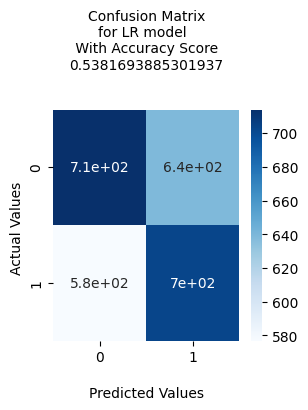

Classifier : LR ===> Training duration : 0.701995849609375 sec


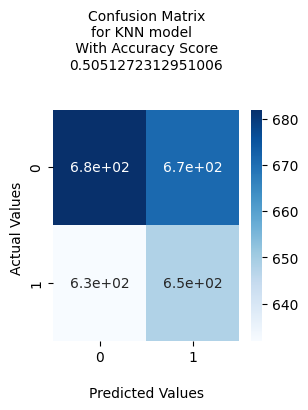

Classifier : KNN ===> Training duration : 0.08072519302368164 sec


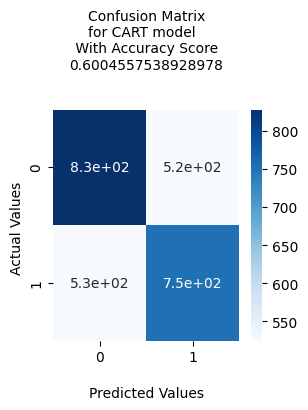

Classifier : CART ===> Training duration : 0.5028629302978516 sec


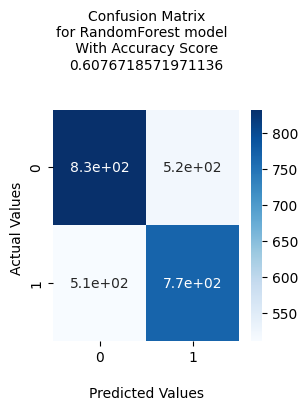

Classifier : RandomForest ===> Training duration : 2.0873820781707764 sec


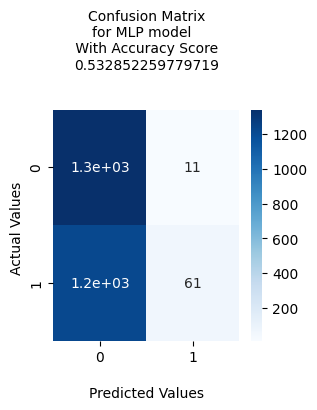

Classifier : MLP ===> Training duration : 19.01926875114441 sec


In [119]:
y_pred = []
train_time = []
for name, model in models:
    tic = time.time()
    model.fit(X_train, y_train)
    toc = time.time()
    
    y_pred = model.predict(X_test)
    train_time.append(toc - tic)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    cf_matrix_score = get_values_confusion_matrix(conf_matrix)
    plt.rcParams["figure.figsize"] = (3,3)
    ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix\n' 
                 + 'for '+name+' model ' 
                 + ' \n' 
                 + ' With Accuracy Score \n'
                 + str(cf_matrix_score[1])
                 + '\n\n', fontsize=10);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()
    
    print("Classifier : {} ===> Training duration : {} sec".format(name, train_time[-1]))
    

The CART and Random Forest have the highest number of True positive True Negative in theire diagonal of the confusion matrix, Hence they have the best result between the 5 classifiers.

#### Computing the AUC of ROC and choosing the best model for these data using the test data

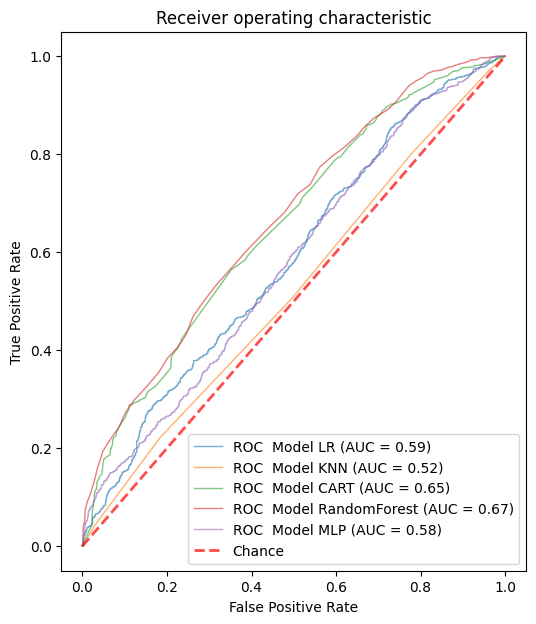

In [120]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

y_prob = []

for name, model in models:
    y_prob.append(model.predict_proba(X_test)[:,1])
    
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
plt.figure(figsize=(6,7))
for idx, y_clf in enumerate(y_prob):
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, y_clf)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.6,
             label='ROC  Model %s (AUC = %0.2f)' % (models[idx][0], roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.7)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

##### I chose to do Hyperparameter tuning for the Random Forest Classifier

In [99]:
#Number of trees in random forest
n_estimators = np.linspace(start = 1200, stop = 3000, num = 10, dtype='int32')
#Number of features to consider at every split
max_features = [5,6,7,8,10]
#Maximum number of levels in tree
max_depth = list(np.linspace(30, 80, num = 5, dtype='int32'))
max_depth.append(None)
#Minimum number of samples required to split a node
min_samples_split = [10, 50, 80]
#Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 40]
#Method of selecting samples for training each tree
bootstrap = [True, False]
#Information critereon  
criterion=['gini']

# Random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion' : criterion
              }

# Random forest Base model to tune
rf_fit = RandomForestClassifier()

rf_random_fit = RandomizedSearchCV(estimator = rf_fit, param_distributions = random_grid, n_iter = 30, cv = 3, random_state=1995, n_jobs = -1)

In [100]:
TrainY = y_train.squeeze()
# Fit the random search model
rf_random_fit.fit(X_train, TrainY)
best_rf = rf_random_fit.best_estimator_

In [101]:
best_rf.score(X_test,y_test)

0.5989365742499051